# **Simple Recommender**

The Simple Recommender provides users with generalized recommendations based on genre and movie rating/popularity. The underlying premise behind this recommender is that popular movies are more likely to be liked by the average audience. This model does not provide personalized recommendations based on the user's preferences.

The model is implemented as follows: 
1. rank movies based on IMDB formula
2. sort movies by this rating mechanism (e.g get the top 10 movies) 
3. pass in a genre argument to find the best movies in a specific genre 
4. add addtion filters to expand this recommender 

In [28]:
# import libraries 

import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from matplotlib import pyplot as plt

import warnings; warnings.simplefilter('ignore')

In [2]:
# load the dataset

md = pd.read_csv('data/movies_metadata.csv',low_memory=False)
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


We can then pre-process/clean this dataset:

In [3]:
# For the colum genres: 

# fill all instances of NA/NaN values with '[]' as the genre column is supposed to be a list
# (literal_eval) evaluate strings in terms of dictionaries
# The function at the end will return all dictionary values associated with key name within your inputs if they're lists. Otherwise, that'll be an empty list.

md['genres_list'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


We can use the IMDB weighted ratings to come up with our Top Movies Chart. It is represented as follows:

Weighted Rating (WR) =  (v/(v+m)*R)+(m/(v+m)*C) where,

1. v is the number of votes for the movie
2. m is the minimum votes required to be listed in the chart
3. R is the average rating of the movie
4. C is the mean vote across the whole report

The next step is to determine an appropriate value for v ,m ,R and C, and write a function to calculate the weighted rating. 

In [4]:
m = md['vote_count'].quantile(0.95)
C = md['vote_average'].mean()
v = md['vote_count']
R = md['vote_average']

In [5]:
m

434.0

In [6]:
C

5.618207215133889

Therefore, to qualify to be considered for the chart, a movie has to have at least **434** TMDB votes. We also see that the average rating for a movie on is **5.618** on a scale of 10. 

We can create a dataframe to sort out the movies based on their ratings.

1. fix the release_date to just year, because no one really care the actual date.
2. Runtime of the moive should be integers. 
3. the weighted_rating rounds to 1 decimal. 

In [7]:
# only include the year the movie comes out 

md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [8]:
Mycolumns = ['title','original_language','year','runtime','genres_list','vote_count','vote_average'] 

dataframe=md[Mycolumns]

In [9]:
# calculate the weighted_rating

dataframe['weighted_rating'] = ((v/(v+m) * R) + (m/(m+v) * C))

In [10]:
TOP_rated = dataframe[(dataframe["vote_count"] >= m) & (dataframe['vote_count'].notnull()) & (dataframe['runtime'].notnull())]

TOP_rated['vote_count'] = TOP_rated['vote_count'].astype('int')
TOP_rated['runtime'] = TOP_rated['runtime'].astype('int')
TOP_rated['weighted_rating']=TOP_rated['weighted_rating'].round(decimals = 1)

In [11]:
TOP_rated.head()

,title,original_language,year,runtime,genres_list,vote_count,vote_average,weighted_rating
0,Toy Story,en,1995,81,"[Animation, Comedy, Family]",5415,7.7,7.5
1,Jumanji,en,1995,104,"[Adventure, Fantasy, Family]",2413,6.9,6.7
5,Heat,en,1995,170,"[Action, Crime, Drama, Thriller]",1886,7.7,7.3
9,GoldenEye,en,1995,130,"[Adventure, Action, Thriller]",1194,6.6,6.3
15,Casino,en,1995,178,"[Drama, Crime]",1343,7.8,7.3


In [12]:
TOP_rated.shape

(2274, 8)

In total, we have 2274 movies that qualify to be on our chart. We can further demonstrate the **top 10 movies** using this dataset. 

In [13]:
# demonstrate the top 10 movies in our chart 

TOP_rated.sort_values('weighted_rating', ascending=False).head(10)

,title,original_language,year,runtime,genres_list,vote_count,vote_average,weighted_rating
314,The Shawshank Redemption,en,1994,142,"[Drama, Crime]",8358,8.5,8.4
834,The Godfather,en,1972,175,"[Drama, Crime]",6024,8.5,8.3
12481,The Dark Knight,en,2008,152,"[Drama, Action, Crime, Thriller]",12269,8.3,8.2
292,Pulp Fiction,en,1994,154,"[Thriller, Crime]",8670,8.3,8.2
2843,Fight Club,en,1999,139,[Drama],9678,8.3,8.2
522,Schindler's List,en,1993,195,"[Drama, History, War]",4436,8.3,8.1
351,Forrest Gump,en,1994,142,"[Comedy, Drama, Romance]",8147,8.2,8.1
23673,Whiplash,en,2014,105,[Drama],4376,8.3,8.1
3030,The Green Mile,en,1999,189,"[Fantasy, Drama, Crime]",4166,8.2,8.0
289,Leon: The Professional,fr,1994,110,"[Thriller, Crime, Drama]",4293,8.2,8.0


# **Genre-based Recommender**

The next step is to consider the **genre** of the movie, and recommend popular movies in a specific domain. 

In [15]:
# separate the genre lists for each movie 

s = md.apply(lambda x: pd.Series(x['genres_list']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres_list', axis=1).join(s)

In [24]:
# First, we can have an idea of how many genres there are

l_genres = md['genres'].apply(literal_eval).apply(lambda x: [i['name'] for i in x]).sum()
count_genres=Counter(l_genres)

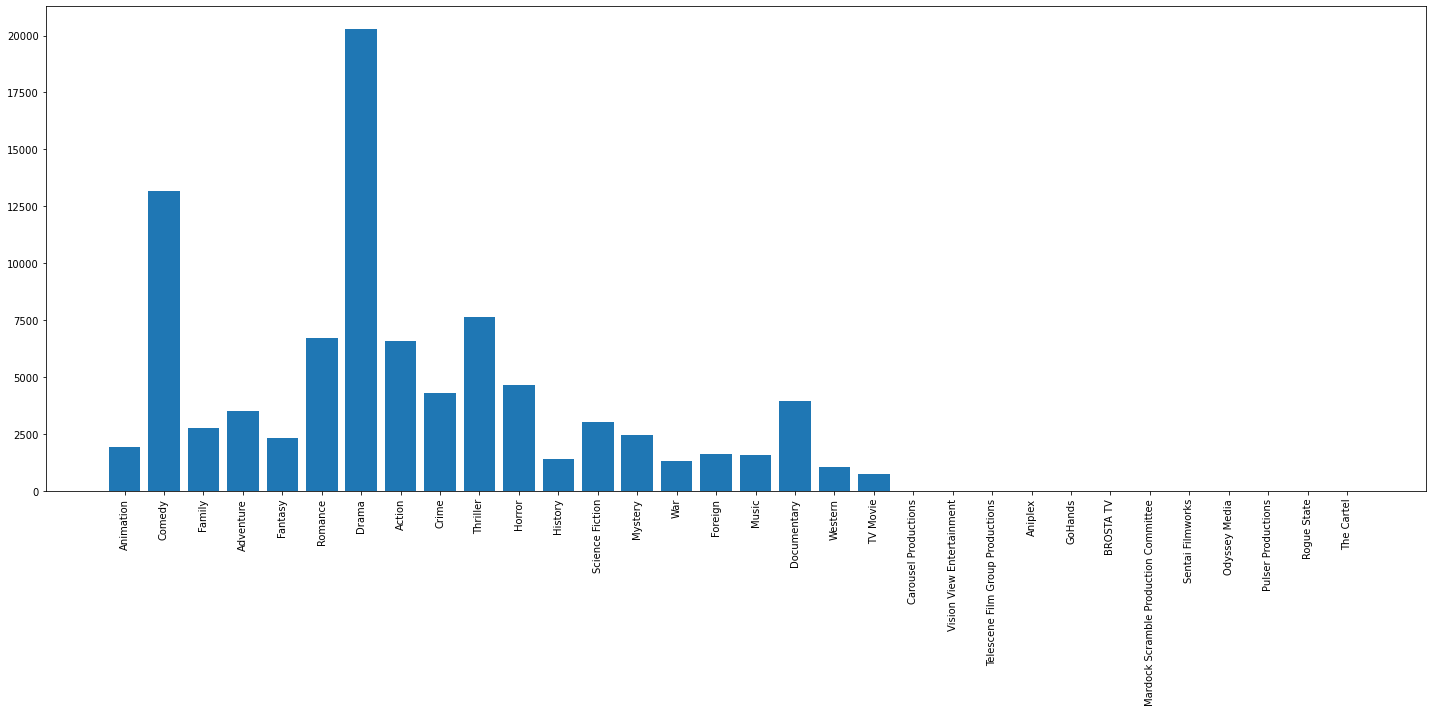

In [44]:
# plot a diagram to show the distributions of genres 

plt.bar(count_genres.keys(), count_genres.values())
plt.xticks(rotation='vertical')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

There are over **20000** movies categorised as "Drama" and around **12500** movies classified as "Comedy." There are also a great number of films categorised as "Romance," "Action," and "Thriller."

In [16]:
# build a function that takes a specific genre and a percentile and outputs top 250 movies based on their ratings. 

def build_chart(genre, percentile):
    df = gen_md[gen_md['genre'] == genre]
    C = df['vote_average'].mean()
    m = df['vote_count'].quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull())][['title','original_language', 'year', 'runtime', 'vote_count', 'vote_average']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['runtime'] = qualified['runtime'].astype('int')
    
    qualified['IMDB_rating'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified['IMDB_rating']=qualified['IMDB_rating'].round(decimals = 1)
    qualified = qualified.sort_values('IMDB_rating', ascending=False).head(250)
    
    return qualified

In [17]:
build_chart('Romance',0.85).head(15)

,title,original_language,year,runtime,vote_count,vote_average,IMDB_rating
10309,Dilwale Dulhania Le Jayenge,hi,1995,190,661,9.1,8.7
40251,Your Name.,ja,2016,106,1030,8.5,8.3
351,Forrest Gump,en,1994,142,8147,8.2,8.2
1132,Cinema Paradiso,it,1988,124,834,8.2,8.0
22168,Her,en,2013,126,4215,7.9,7.9
40882,La La Land,en,2016,128,4745,7.9,7.9
7208,Eternal Sunshine of the Spotless Mind,en,2004,108,3758,7.9,7.9
19901,Paperman,en,2012,7,734,8.0,7.8
15530,Mr. Nobody,en,2009,156,1616,7.9,7.8
3189,City Lights,en,1931,87,444,8.2,7.8


**Next step:**

1. We can consider additional features such as original language, year, or runtime and combines all of these features to create a more complete chart/recommender.
2. We may also compare how much the 'IMDB rating' differs from the 'vote average.'